In [3]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy import log, exp
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler
import glob
import os
sns.set_style("white")

## Fitting a mixed effect model Poisson GLM with ADVI mini_batch

1. Regularize using GLM Lasso
    - The first step in the analysis is, for each study, to fit a regularizing GLM LASSO to help identify the primary factors driving pig movement.  Particularly, we want to see how foraging resources affect pig movement as main effects and as interactive effects with other available resources.

2. Fit a mixed effect model using ADVI
    - Once we've identified a simple minimalish model, we want to more robustly extract the population-level effects by fitting a mixed effects model in which we allow random effects of individuals. We will use Mini-batch ADVI to fit these models, hopefully without losing too much realism in the predictions.  This will be a good way to include error in the predictions
    

In [4]:
gfiles = glob.glob("/Users/mqwilber/Repos/rsf_swine/results/glmdata_by_study/*.csv")
pigattrib = pd.read_csv("/Users/mqwilber/Repos/rsf_swine/data/formatted/pig_attributes.csv")[['pigID', "sex"]]

In [ ]:
# Fit each data set using ADVI and look at the best fit predictors
#pm_fits = {}
batches = 500
advi_samps = 40000

for f in gfiles:
    
    study = os.path.basename(f).split(".")[0]
    
    if (study == "florida") or (study == "txcamp"):
        
        print("Working on {0}".format(study))
        tdat = pd.read_csv(f)
        tdat = pd.merge(tdat, pigattrib, on="pigID")

        include_vars = ["crw",
                        "canopycover_loc", "canopycover_grad",
                        "water_loc", "water_grad",
                        "ndvi_loc", "ndvi_grad",
                        "masting_loc","masting_grad",
                        "crop_loc", "crop_grad",
                        "precipitation_loc", "temperature_loc"]

        # Response variable and offset
        z = tdat.z.values
        tau = tdat.tau.values

        # Build and standardize the design matrix
        X = pd.DataFrame(StandardScaler().fit_transform(X=tdat[include_vars].values))
        X.columns = include_vars
        
        # Make a sex effect
        malevect = (pd.get_dummies(tdat.sex)['M'] == 0).astype(np.int)
        #X.loc[:, "male"] = malevect
        Xfull = X

        # Build the random effects matrix
        pigIDs = pd.Series(tdat.pigID)
        unqpigIDs = pd.Series(pigIDs.unique()).reset_index()
        unqpigIDs.columns = ['pigID_index', 'pigID']
        pigIDs_num = pd.merge(pd.DataFrame(pigIDs), unqpigIDs, on="pigID").pigID_index
        Z = pd.get_dummies(tdat.pigID)

        # Individual-level random effects 
        Zcover_loc = Xfull.canopycover_loc[:,np.newaxis] * Z
        Zcover_grad = Xfull.canopycover_grad[:,np.newaxis] * Z
        Zcrop_loc = Xfull.crop_loc[:,np.newaxis] * Z
        Zcrop_grad = Xfull.crop_grad[:,np.newaxis] * Z
        Zmasting_loc = Xfull.masting_loc[:,np.newaxis] * Z
        Zmasting_grad = Xfull.masting_grad[:,np.newaxis] * Z
        Zndvi_loc = Xfull.ndvi_loc[:, np.newaxis] * Z
        Zndvi_grad = Xfull.ndvi_grad[:, np.newaxis] * Z
        Zwater_loc = Xfull.water_loc[:, np.newaxis] * Z
        Zwater_grad = Xfull.water_grad[:, np.newaxis] * Z

        # Direcitonal persistence
        crw = Xfull[["crw"]].values[:, 0]
        # male = Xfull[['male']].values[:, 0]

        # Mini-batch variables
        batch = batches
        crw_t = pm.Minibatch(crw, batch)
        # male_t = pm.Minibatch(male, batch)
        z_t = pm.Minibatch(z, batch)
        tau_t = pm.Minibatch(tau, batch)
        Z_t1 = pm.Minibatch(Zcover_loc.values, batch)
        Z_t2 = pm.Minibatch(Zcover_grad.values, batch)
        Z_t3 = pm.Minibatch(Zcrop_loc.values, batch)
        Z_t4 = pm.Minibatch(Zcrop_grad.values, batch)
        Z_t5 = pm.Minibatch(Zmasting_loc.values, batch)
        Z_t6 = pm.Minibatch(Zmasting_grad.values, batch)
        Z_t7 = pm.Minibatch(Zndvi_loc.values, batch)
        Z_t8 = pm.Minibatch(Zndvi_grad.values, batch)
        Z_t9 = pm.Minibatch(Zwater_loc.values, batch)
        Z_t10 = pm.Minibatch(Zwater_grad.values, batch)

        tmodel = pm.Model()
        numparams = X.shape[1]
        numpigs = Z.shape[1]
        popsd = 2

        with tmodel:

            # Fixed effects
            alpha = pm.Normal('alpha', mu=0, sd=5, shape=1)
            beta_crw = pm.Normal('beta_crw', mu=0, sd=3)
            # beta_male = pm.Normal('beta_male', mu=0, sd=3)
            
            # Population-level effects
            coverloc_pop = pm.Normal('coverloc_pop', mu=0, sd=popsd)
            covergrad_pop = pm.Normal('covergrad_pop', mu=0, sd=popsd)
            croploc_pop = pm.Normal('croploc_pop', mu=0, sd=popsd)
            cropgrad_pop = pm.Normal('cropgrad_pop', mu=0, sd=popsd)
            mastingloc_pop = pm.Normal('mastingloc_pop', mu=0, sd=popsd)
            mastinggrad_pop = pm.Normal('mastinggrad_pop', mu=0, sd=popsd)
            ndviloc_pop = pm.Normal('ndviloc_pop', mu=0, sd=popsd)
            ndvigrad_pop = pm.Normal('ndvigrad_pop', mu=0, sd=popsd)
            waterloc_pop = pm.Normal('waterloc_pop', mu=0, sd=popsd)
            watergrad_pop = pm.Normal('watergrad_pop', mu=0, sd=popsd)
            
            # From Buderman et al. 2018
            logphi = pm.Normal('logphi', mu=0, sd=0.04, shape=9)
            
            # Random effect variances
            sigma_coverloc = pm.HalfNormal('sigma_cover', sd=1)
            sigma_covergrad = tt.exp(logphi[0]) * sigma_coverloc
            sigma_croploc = tt.exp(logphi[1]) * sigma_coverloc
            sigma_cropgrad = tt.exp(logphi[2]) * sigma_coverloc
            sigma_mastingloc = tt.exp(logphi[3]) * sigma_coverloc
            sigma_mastinggrad = tt.exp(logphi[4]) * sigma_coverloc
            sigma_ndviloc = tt.exp(logphi[5]) * sigma_coverloc
            sigma_ndvigrad = tt.exp(logphi[6]) * sigma_coverloc
            sigma_waterloc = tt.exp(logphi[7]) * sigma_coverloc
            sigma_watergrad = tt.exp(logphi[8]) * sigma_coverloc
            
            # Random effects
            beta_coverloc = pm.Normal('beta_coverloc', mu=coverloc_pop, sd=sigma_coverloc, shape=numpigs)
            beta_covergrad = pm.Normal('beta_covergrad', mu=covergrad_pop, sd=sigma_covergrad, shape=numpigs)
            beta_croploc = pm.Normal('beta_croploc', mu=croploc_pop, sd=sigma_croploc, shape=numpigs)
            beta_cropgrad = pm.Normal('beta_cropgrad', mu=cropgrad_pop, sd=sigma_cropgrad, shape=numpigs)
            beta_mastingloc = pm.Normal('beta_mastingloc', mu=mastingloc_pop, sd=sigma_mastingloc, shape=numpigs)
            beta_mastinggrad = pm.Normal('beta_mastinggrad', mu=mastinggrad_pop, sd=sigma_mastinggrad, shape=numpigs)
            beta_ndviloc = pm.Normal('beta_ndviloc', mu=ndviloc_pop, sd=sigma_ndviloc, shape=numpigs)
            beta_ndvigrad = pm.Normal('beta_ndvigrad', mu=ndvigrad_pop, sd=sigma_ndvigrad, shape=numpigs)
            beta_waterloc = pm.Normal('beta_waterloc', mu=waterloc_pop, sd=sigma_waterloc, shape=numpigs)
            beta_watergrad = pm.Normal('beta_watergrad', mu=watergrad_pop, sd=sigma_watergrad, shape=numpigs)

            # Expected value of outcome
            loglam = tt.log(tau_t) + alpha + beta_crw*crw_t \
                     + theano.dot(Z_t1, beta_coverloc) + theano.dot(Z_t2, beta_covergrad) \
                     + theano.dot(Z_t3, beta_croploc) + theano.dot(Z_t4, beta_cropgrad) \
                     + theano.dot(Z_t5, beta_mastingloc) + theano.dot(Z_t6, beta_mastinggrad) \
                    + theano.dot(Z_t7, beta_ndviloc) + theano.dot(Z_t8, beta_ndvigrad) \
                    + theano.dot(Z_t9, beta_waterloc) + theano.dot(Z_t10, beta_watergrad)

            # Likelihood (sampling distribution) of observations
            Y_obs = pm.Poisson('Y_obs', mu=tt.exp(loglam), observed=z_t, total_size=Xfull.shape[0])

            # Fit ADVI
            pfit = pm.fit(n=advi_samps, method="advi", 
                        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

        pm_fits[study] = pfit 

Working on txcamp


Average Loss = 2.9152e+06: 100%|██████████| 40000/40000 [17:42<00:00, 37.64it/s]
Finished [100%]: Average Loss = 2.9148e+06


Working on florida


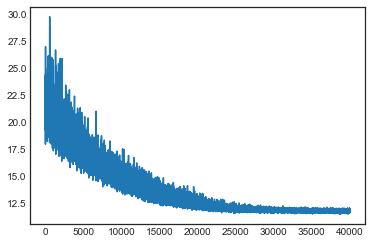

In [112]:
plt.plot(np.log(pm_fits['mo_kurt0'].hist))

**Thought**: The random effect component might actually be quite useful when looking at the population-level effect.  True, each pig is sampled over a different period of time which is inevitably going to affect resource selection as this varies temporally.  However, if we are interested in a general population-level effect, then including the random effect will inevitably weight pigs with a longer sampling period more and allow these effect to have a greater influence on the population-level mean than the pigs that are sampled less. So while we are not accounting for time explicitly, and random effect approach does implictly allow for variation that is inherent in different times. 

---

### Plot the population-level effects

Compare the population-level effects across populations

In [116]:
# Draw from the ADVI posterior
varnames = ['beta_crw', 'coverloc_pop', 'covergrad_pop', 'croploc_pop', 'cropgrad_pop', 'mastingloc_pop',
 'mastinggrad_pop','ndviloc_pop', 'ndvigrad_pop', 'waterloc_pop', 'watergrad_pop']

ttraces = {study: pm_fits[study].sample(draws=5000) for study in pm_fits.keys()}

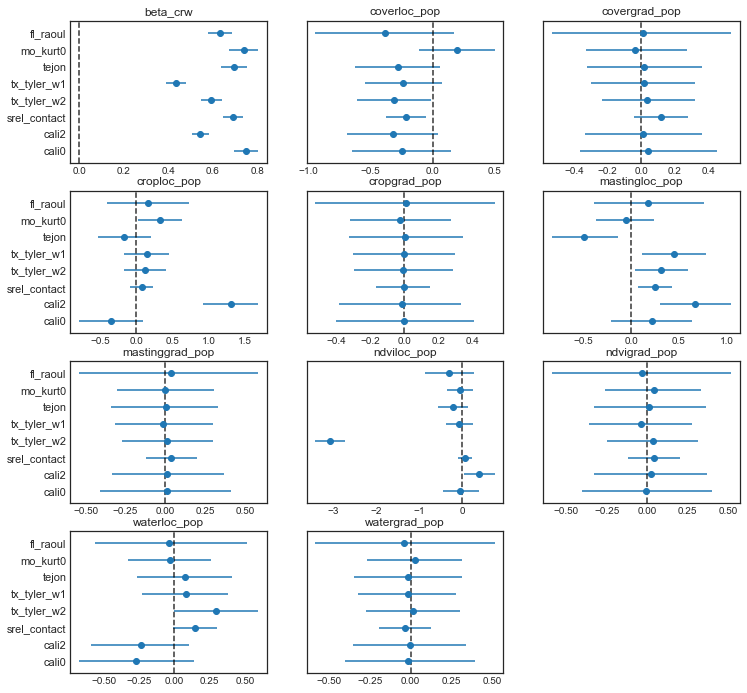

In [131]:
# Plot effects across populations
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)
axes = axes.ravel()

yvals = np.linspace(0, 1, num=len(pm_fits.keys()))
for i, vname in enumerate(varnames):
    
    tcoefs = pd.DataFrame(index=pm_fits.keys(), columns=["lower", "median", "upper"])
    
    for study in pm_fits.keys():
        
        quants = pm.quantiles(ttraces[study])
        tcoefs.loc[study, :] = (quants[vname][2.5], quants[vname][50], quants[vname][97.5])
        
    axes[i].errorbar(tcoefs['median'], yvals, 
                     xerr=np.array([tcoefs['median'] - tcoefs.lower, tcoefs.upper - tcoefs['median']]), 
                     linestyle="", marker="o")
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].vlines(0, *axes[i].get_ylim(), linestyle="--", alpha=0.8)
    axes[i].set_yticks(yvals)
    axes[i].set_yticklabels(tcoefs.index, size=11)
    axes[i].set_title(vname) 

axes[11].tick_params(labelbottom="off")
axes[11].spines['bottom'].set_visible(False)
axes[11].spines['top'].set_visible(False)
axes[11].spines['right'].set_visible(False)
axes[11].spines['left'].set_visible(False)

Many of the effects are consistent with the lasso analysis, though this approach seems more prone to yield extreme results (e.g. the effect of NDVI loc in `tx_tyler_w2`) or `croploc` in `cali2`.  The main takeaways are consistent though:

1. Direction persistence in movement is consistent across populations
2. Generally, pigs more slower in cells with higher canopy cover
3. Generally, pigs more toward cells with higher canopy cover
4. The effects of anthropogenic and natural forage on pig movement varies pretty significantly across populations.  Why? 
    - Other than Tejon where pigs tend to spend more time in the masting layer, pigs generally tend to spend less time in areas with higher masting tree density in other studies.
    - Not sure why that is

## Model 2: Seasonal effects of forage

This model explores the effects of season (i.e. an interaction between precipitation and temperature) on the the selection for foraging resources.  A population-level GAM showed that there is some strong seasonality in these effects (though not a whole lot of consistency).  Now we want to understand whether the population-level mean of foraging varies with temperature and precipitation. 

In [177]:
pm.plots.forestplot?

In [98]:
loofit

LOO_r(LOO=105661.08576787316, LOO_se=438.7410735924591, p_LOO=50953.22568059581)

Build a PyMC3 model using MiniBatch.

In [19]:
import theano
import theano.tensor

Xfull = Xtej
poisson_model = pm.Model()
numparams = Xfull.shape[1]

batch = 1000
X_t = pm.Minibatch(Xfull.values, batch)
z_t = pm.Minibatch(z, batch)
tau_t = pm.Minibatch(tau, batch)
Z_t = pm.Minibatch(Z.values, batch)

numrand = 1

# pigID_t = pm.Minibatch(pigIDs_num, batch)
numpigs = len(np.unique(tejondat.pigID))

with poisson_model:

    # Hyper priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Normal('beta', mu=0, sd=3, shape=numparams)
    sigma_a = pm.HalfCauchy("sigma_a", beta=2)
    
    phi_vect = pm.Lognormal('phi_vect', mu=0, sd=0.04, shape=numrand - 1)
    sigma_vect = sigma_a * phi_vect
    sigma_full = T.concatenate([T.stack(sigma_a), sigma_vect])
    
    # Random effect of individual pig on general movement
    a = pm.Normal('a', mu=alpha, sd=sigma_full[0], shape=numpigs)
    
#     # Random effect of individual pig on crop_grad
#     b = pm.Normal('b', mu=0, sd=sigma_full[1], shape=numpigs)
    
    # Expected value of outcome
    loglam = log(tau_t) + theano.dot(X_t, beta) + theano.dot(Z_t, a) #+ theano.dot(Z2_t, b)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Poisson('Y_obs', mu=np.exp(loglam), observed=z_t, total_size=Xfull.shape[0])

In [20]:
with poisson_model:
    inference = pm.ADVI()
    modfit = pm.fit(n=40000, method="advi", 
                callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = 1.9639e+06: 100%|██████████| 20000/20000 [08:49<00:00, 37.78it/s]
Finished [100%]: Average Loss = 1.9592e+06


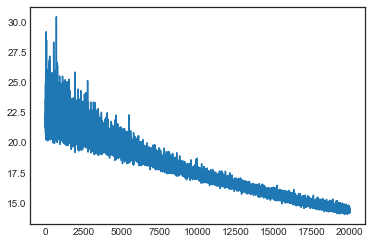

In [21]:
plt.plot(np.log(modfit.hist))

In [22]:
trace = modfit.sample(draws=10000)

In [23]:
coef = pm.summary(trace)
coef.loc[:, "names"] = ["intercept"] +  list(Xfull.columns) + list(range(13)) + ['sigma_a']
coef

,mean,sd,mc_error,hpd_2.5,hpd_97.5,names
alpha,-4.129431,0.296488,0.003312,-4.733080,-3.571257,intercept
beta__0,0.002429,0.050219,0.000455,-0.098305,0.097168,crw_z
beta__1,-4.803344,0.233891,0.002293,-5.252578,-4.338377,sexM
beta__2,-0.004168,0.060042,0.000596,-0.119002,0.114498,canopycover_loc_z
beta__3,-0.004093,0.050405,0.000471,-0.100899,0.095543,canopycover_grad_z
beta__4,-0.569699,0.053607,0.000569,-0.673234,-0.463805,water_loc_z
beta__5,-0.004364,0.051589,0.000536,-0.107757,0.094442,water_grad_z
beta__6,-0.342246,0.062658,0.000566,-0.459581,-0.217766,ndvi_loc_z
beta__7,0.004061,0.053107,0.000631,-0.103310,0.105745,ndvi_grad_z
beta__8,-1.103853,0.075082,0.000702,-1.246082,-0.953468,masting_loc_z


## Time-varying pig movement

First fitting Tejon trajectories

In [165]:
Xtej_gam = pd.read_csv("../results/temp_Xgam_tej.csv")

In [175]:
gam_model = pm.Model()

numparams = Xtej_gam.shape[1]

batch = 1000
X_t = pm.Minibatch(Xtej_gam.values, batch)
z_t = pm.Minibatch(z, batch)
tau_t = pm.Minibatch(tau, batch)

with gam_model:

    # Hyper priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Normal('beta', mu=0, sd=1, shape=numparams)
    
    loglam = log(tau_t) + alpha + theano.dot(X_t, beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Poisson('Y_obs', mu=np.exp(loglam), observed=z_t, total_size=Xtej_gam.shape[0])

In [176]:
# Fit the Tejon GAM model
with gam_model:
    tej_inference = pm.ADVI()
    tej_gam = pm.fit(n=40000, method="advi", 
                callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = 7.2948e+09:   0%|          | 24/40000 [00:05<2:32:26,  4.37it/s]
Interrupted at 24 [0%]: Average Loss = 7.7018e+09


In [167]:
Xtej_gam.shape

(787320, 49)

In [177]:
Xtej_gam.mean(axis=0)

crw_z             0.000000
sexM              0.311258
hour_2            0.232626
hour_3            0.107256
hour_4            0.096047
hour_5            0.290658
month_1           0.294783
month_2           0.179124
month_4           0.131572
month_5           0.284762
cover_loc_1      -0.121597
cover_loc_2      -0.028810
cover_loc_3       0.063239
cover_loc_4       0.073328
cover_loc_5       0.013840
cover_grad_1      0.000000
cover_grad_2      0.000000
cover_grad_3      0.000000
cover_grad_4      0.000000
cover_grad_5      0.000000
water_loc_1       0.008950
water_loc_2      -0.002165
water_loc_3       0.012705
water_loc_4       0.022857
water_loc_5      -0.042347
water_grad_2      0.000000
water_grad_5      0.000000
crop_loc_1        0.121118
crop_loc_2        0.073570
crop_loc_3       -0.000841
crop_loc_4       -0.094952
crop_loc_5       -0.098895
crop_grad_3       0.000000
crop_grad_4       0.000000
masting_loc_1     0.054018
masting_loc_3     0.022999
masting_loc_4    -0.006282
m